In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy.io.wavfile import read, write
import numpy as np
from scipy.io.wavfile import write
#read input
sampling_rate, input_audio = wavfile.read('.\\HW2_Mix.wav')
print(sampling_rate)
is_out_exist = os.path.exists('output')
# Create a new directory because it does not exist
if not is_out_exist:
    os.makedirs('output')
    print("The new directory is created!")

44100


C:\Users\吳泊諭\AppData\Local\Temp\ipykernel_23768\805283498.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, input_audio = wavfile.read('.\\HW2_Mix.wav')


In [20]:

def video_saver(input_audio, filename, sampling_rate):
    data = input_audio
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    write(filename, sampling_rate, scaled)
def freq_domain(input_audio, f_sampling_rate, filename):
    F = np.fft.fft(input_audio)
    freqs = np.fft.fftfreq(len(F), 1/f_sampling_rate)
    #truncate negative frequencies
    F = F[freqs >= 0 ]
    freqs = freqs[freqs >= 0 ]
    #truncate frequencies above 1600 Hz
    F = F[freqs < 2000 ]
    freqs = freqs[freqs < 2000]
    plt.plot(freqs, np.abs(F))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title(filename)
    plt.savefig('.\\output\\' + filename +'.png')
    plt.show()
def low_pass_filter(f_cutoff, f_sampling_rate, N, window_type):
    #normalize cutoff frequency
    my_filter = np.zeros((N,))
    f_cutoff = f_cutoff / f_sampling_rate
    mid = int(N/2)
    for i in range(-mid,mid):
        if i!=0:
            my_filter[mid+i] = np.sin(2*np.pi*f_cutoff*i)/(np.pi*i)
        else:
            my_filter[mid] = 2 * f_cutoff
    #convert ideal filter to low pass filter
    my_ideal_filter = window(my_filter, N, window_type)
    return my_ideal_filter
def high_pass_filter(f_cutoff, f_sampling_rate, N, window_type):
    #normalize cutoff frequency
    my_filter = np.zeros((N,))
    f_cutoff = f_cutoff / f_sampling_rate
    mid = int(N/2)
    for i in range(-mid, mid):
        if i!=0:
            my_filter[mid+i] = -np.sin(2*np.pi*f_cutoff*i)/(np.pi*i)
        else:
            my_filter[mid] = 1 - 2 * f_cutoff
    #convert ideal filter to low pass filter
    my_ideal_filter = window(my_filter, N, window_type)
    return my_ideal_filter
def band_pass_filter(f_cutoff_low, f_cutoff_high, f_sampling_rate, N, window_type):
    #normalize cutoff frequency
    my_filter = np.zeros((N,))
    f_cutoff_low = f_cutoff_low / f_sampling_rate
    f_cutoff_high = f_cutoff_high / f_sampling_rate
    mid = int(N/2)
    for i in range(-mid, mid):
        if i!=0:
            my_filter[i] = np.sin(2*np.pi*f_cutoff_high*i)/(np.pi*i) - np.sin(2*np.pi*f_cutoff_low*i)/(np.pi*i)
        else:
            my_filter[i] = 2 * f_cutoff_high - 2 * f_cutoff_low
    #convert ideal filter to low pass filter
    my_ideal_filter = window(my_filter, N, window_type)
    return my_ideal_filter
def window(ideal_filter, N, window_type):
    realistic_filter = ideal_filter.copy()
    for i in range(N):    
        if   window_type == 'rectangular':
            realistic_filter[i] = ideal_filter[i]
        elif window_type == 'hamming':
            realistic_filter[i] = ideal_filter[i] * (0.54+0.46*np.cos(2*np.pi*i/N))
        elif window_type == 'hanning':
            realistic_filter[i] = ideal_filter[i] * (0.5+0.5*np.cos(2*np.pi*i/N))
        elif window_type == 'blackman':
            realistic_filter[i] = ideal_filter[i] * (0.42 - 0.5*np.cos(2*np.pi*i/(N-1)) + 0.08*np.cos(4*np.pi*i/(N-1)))
    return realistic_filter
def masking(input_audio, my_filter, N):
    res = np.zeros(input_audio.shape)
    return np.convolve(input_audio, my_filter, 'same')#speed up line
    for i in range(input_audio.shape[0]):
        for j in range(N):
            if i-j >= 0:
                res[i] = res[i] + input_audio[i-j] * my_filter[j]
    return res
def one_fold_echo(input_audio, delay, gain):
    res = np.zeros(input_audio.shape)
    for i in range(input_audio.shape[0]):
        if i-delay >= 0:
            res[i] = input_audio[i] + gain * input_audio[i-delay]
        else:
            res[i] = input_audio[i]
    return res
def multiple_fold_echo(input_audio, delay, gain):
    res = np.zeros(input_audio.shape)
    for i in range(input_audio.shape[0]):
        if i-delay >= 0:
            res[i] = input_audio[i] + gain * res[i-delay]
        else:
            res[i] = input_audio[i]
    return res
def down_sampling(input_audio, sampling_rate, new_sampling_rate):
    res = []
    target = int(sampling_rate/new_sampling_rate)
    for i in range(input_audio.shape[0]):
        if i%target == 0:
            res.append(input_audio[i])
    res = np.array(res)
    print(input_audio.shape, res.shape)
    return res
def time_domain(input_audio, filename):
    plt.plot(input_audio)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(filename)
    plt.savefig('.\\output\\' + filename +'.png')
    plt.show()

# INPUT FREQUENCY DOMAIN

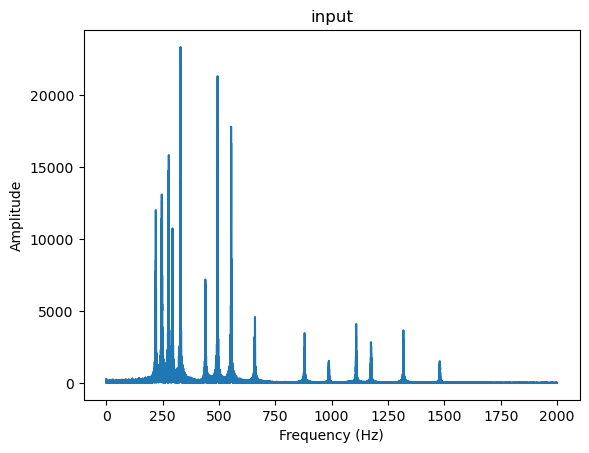

In [21]:
freq_domain(input_audio=input_audio, f_sampling_rate=sampling_rate, filename='input')

# 小蜜蜂

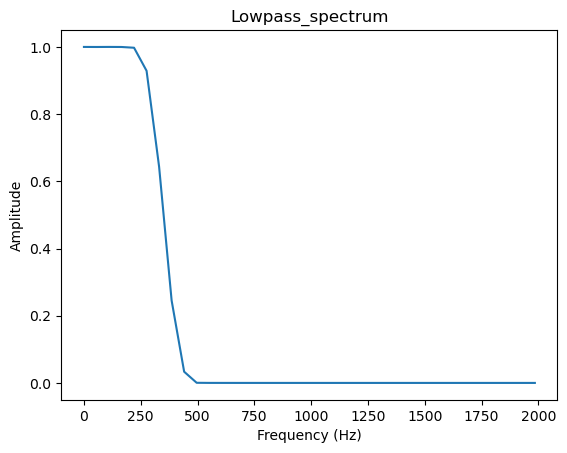

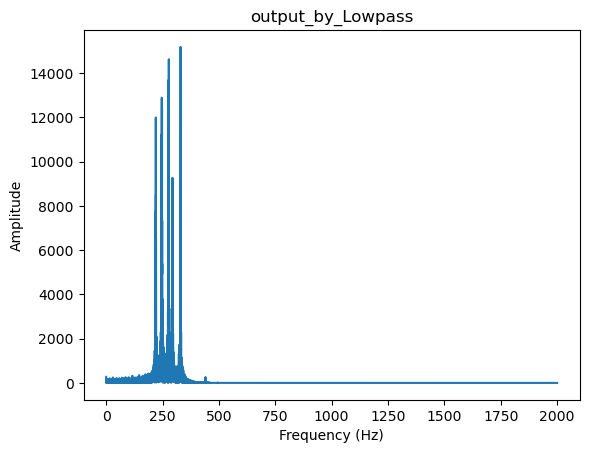

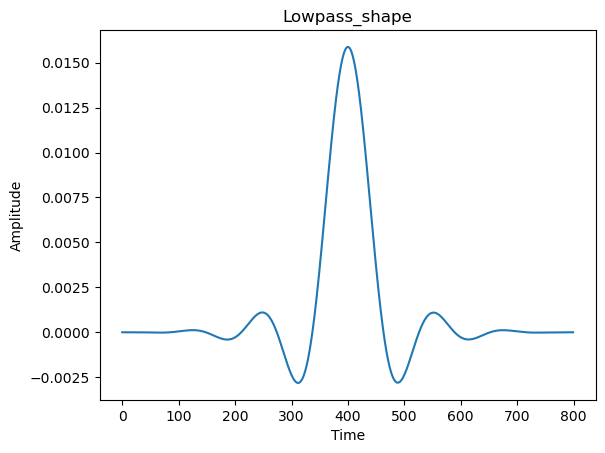

(639794,) (29082,)


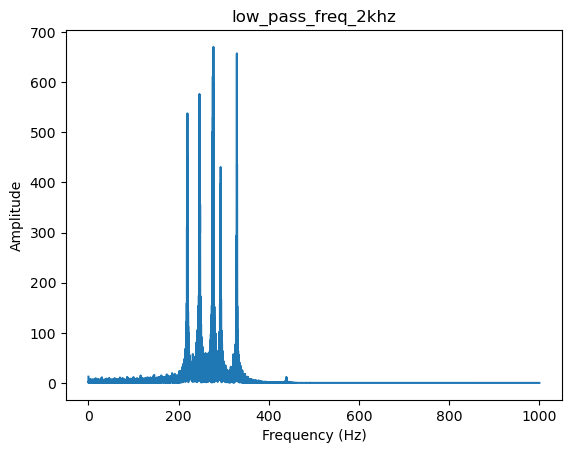

In [22]:
f_cutoff = 350
N = 800
my_low_pass_filter = low_pass_filter(f_cutoff=f_cutoff, f_sampling_rate=sampling_rate, N = N, window_type='blackman')
freq_domain(input_audio=my_low_pass_filter, f_sampling_rate=sampling_rate, filename='Lowpass_spectrum')
res = masking(input_audio=input_audio, my_filter=my_low_pass_filter, N=800)
tmp = res.copy()
freq_domain(input_audio=res, f_sampling_rate=sampling_rate, filename='output_by_Lowpass')
time_domain(input_audio=my_low_pass_filter, filename='Lowpass_shape')
base_store_name = '.\\output\\Lowpass_'+ str(f_cutoff) + '_' + str(N)
video_saver(input_audio=res, sampling_rate=sampling_rate, filename= base_store_name + '.wav')
one_fold_res = one_fold_echo(input_audio=res, delay=1000, gain=0.5)
multi_fold_res = multiple_fold_echo(input_audio=res, delay=1000, gain=0.5)
video_saver(input_audio=one_fold_res, sampling_rate=sampling_rate, filename='.\\output\\Echo_one.wav')
video_saver(input_audio=multi_fold_res, sampling_rate=sampling_rate, filename='.\\output\\Echo_multiple.wav')
new_sampling_rate = 2000
down_sampling_res = down_sampling(input_audio=tmp, sampling_rate=sampling_rate, new_sampling_rate=new_sampling_rate)
freq_domain(input_audio=down_sampling_res, f_sampling_rate=new_sampling_rate, filename='low_pass_freq_2khz')
video_saver(input_audio=down_sampling_res, sampling_rate=new_sampling_rate, filename=base_store_name + '_2kHZ.wav')

# 兩隻老虎

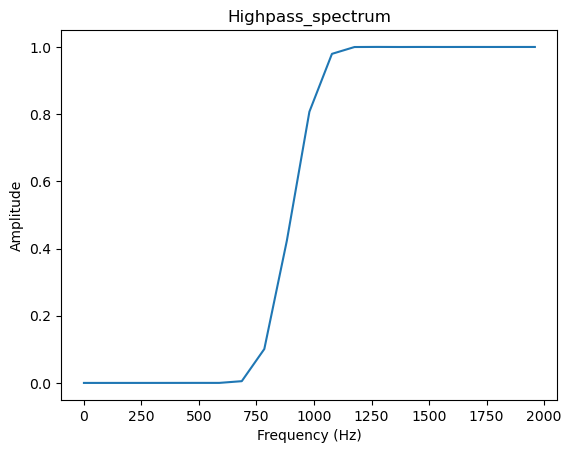

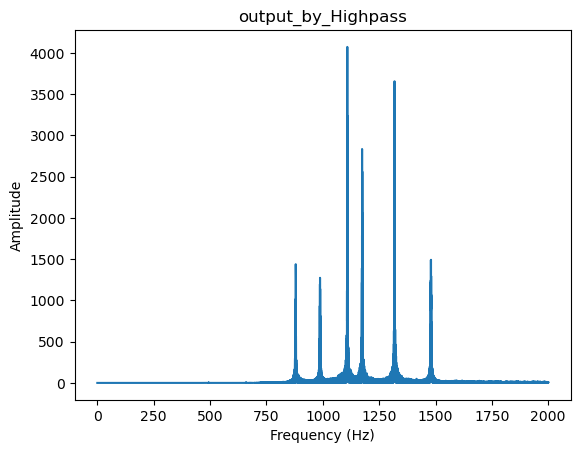

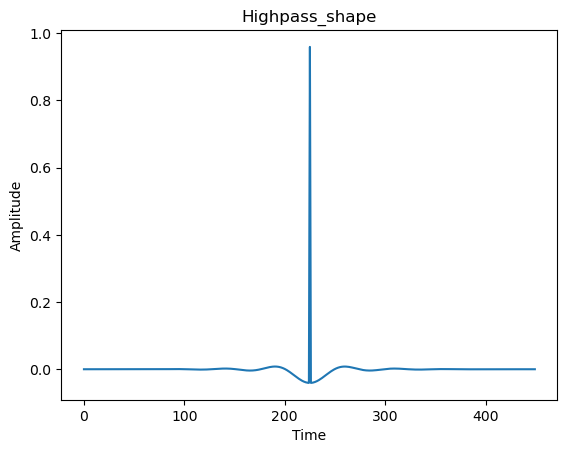

(639794,) (29082,)


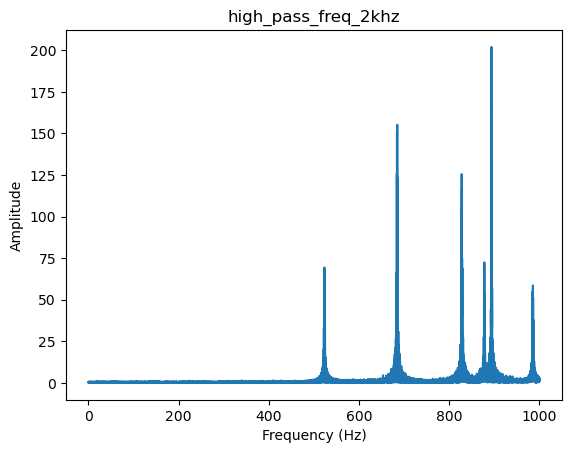

In [23]:
#lib = ['rectangular', 'hamming', 'hanning', 'blackman']
lib = ['blackman']
N = 450
f_cutoff = 900
for name in lib:
    my_high_pass_filter = high_pass_filter(f_cutoff=f_cutoff, f_sampling_rate=sampling_rate, N = N, window_type=name)
    freq_domain(input_audio=my_high_pass_filter, f_sampling_rate=sampling_rate, filename='Highpass_spectrum')
    res = masking(input_audio=input_audio, my_filter=my_high_pass_filter, N = N)
    tmp = res.copy()
    freq_domain(input_audio=res, f_sampling_rate=sampling_rate, filename='output_by_Highpass')
    time_domain(input_audio=my_high_pass_filter, filename='Highpass_shape')
    save_name = '.\\output\\Highpass_'+ str(f_cutoff) + '_' + str(N)
    video_saver(input_audio=res, sampling_rate=sampling_rate, filename=save_name + '.wav')
    
    new_sampling_rate = 2000
    down_sampling_res = down_sampling(input_audio=tmp, sampling_rate=sampling_rate, new_sampling_rate=new_sampling_rate)
    freq_domain(input_audio=down_sampling_res, f_sampling_rate=new_sampling_rate, filename='high_pass_freq_2khz')
    video_saver(input_audio=down_sampling_res, sampling_rate=new_sampling_rate, filename=save_name + '_2kHZ.wav')

# 瑪莉有隻小綿羊

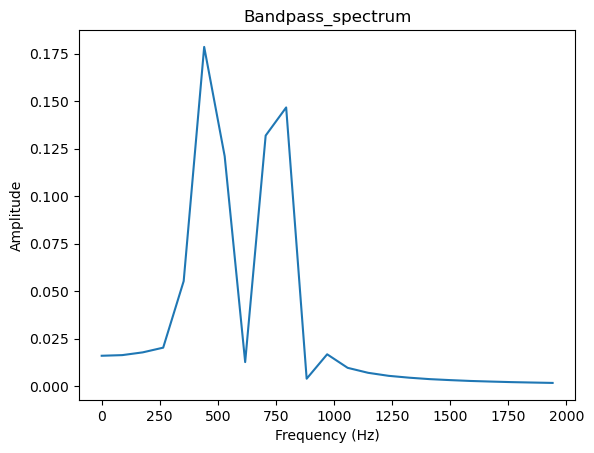

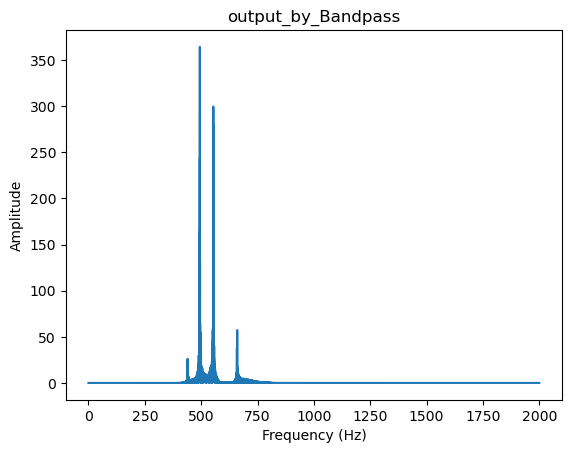

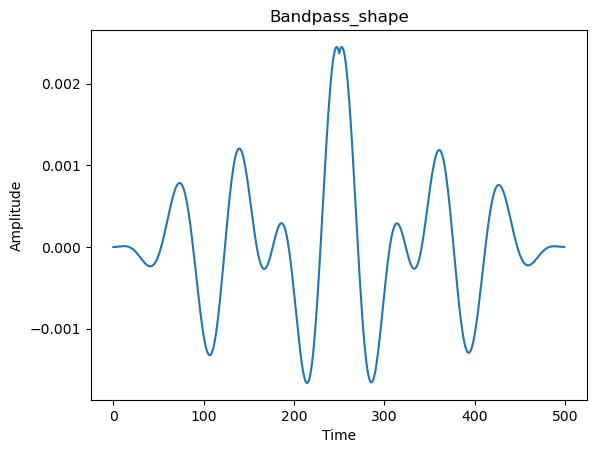

(639794,) (29082,)


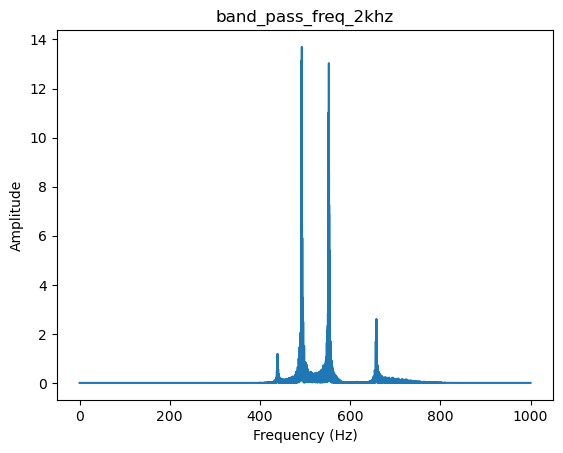

In [24]:
#lib = ['rectangular', 'hamming', 'hanning', 'blackman']
lib = ['blackman']
N = 500
f_cutoff_low = 500
f_cutoff_high = 750
offset = 100
for name in lib:
    hpf = high_pass_filter(f_cutoff=f_cutoff_low + offset, f_sampling_rate=sampling_rate, N = N, window_type=name)
    lpf = low_pass_filter(f_cutoff=f_cutoff_high -offset, f_sampling_rate=sampling_rate, N = N, window_type=name)
    my_band_pass_filter = band_pass_filter(f_cutoff_low=f_cutoff_low,f_cutoff_high=f_cutoff_high, f_sampling_rate=sampling_rate, N = N, window_type=name)
    freq_domain(input_audio=my_band_pass_filter, f_sampling_rate=sampling_rate, filename='Bandpass_spectrum')
    res = masking(input_audio=input_audio, my_filter=my_band_pass_filter, N=N)
    res = masking(input_audio=res, my_filter=hpf, N=N)
    res = masking(input_audio=res, my_filter=lpf, N=N)
    tmp = res.copy()
    freq_domain(input_audio=res, f_sampling_rate=sampling_rate, filename='output_by_Bandpass')
    time_domain(input_audio=my_band_pass_filter, filename='Bandpass_shape')
    save_name = '.\\output\\Bandpass_' + str(f_cutoff_low) + '_' + str(f_cutoff_high)
    video_saver(input_audio=res, sampling_rate=sampling_rate, filename=save_name +'.wav')
    
    new_sampling_rate = 2000
    down_sampling_res = down_sampling(input_audio=tmp, sampling_rate=sampling_rate, new_sampling_rate=new_sampling_rate)
    freq_domain(input_audio=down_sampling_res, f_sampling_rate=new_sampling_rate, filename='band_pass_freq_2khz')
    video_saver(input_audio=down_sampling_res, sampling_rate=new_sampling_rate, filename= save_name + '_2kHZ.wav')